# Player Session Insights
* Use jupyter notebook and spark to support your answers.
* How many sessions are in the dataset?
* How many sessions are completed per country?
* How many sessions are completed per player?
* What is the country with more sessions started during 2018?
* Plot the player sessions completed per country

## Gather the dataset
https://cdn.unityads.unity3d.com/assignments/assignment_data.jsonl.bz2 (30-40 MB)

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [2]:
# I downloaded the json file
df = spark.read.json('assignment_data.jsonl.bz2')

In [3]:
# examine basic structure
if not df.is_cached:
    df.cache()
df.printSchema()
print(df.first())
df.describe().show()

root
 |-- country: string (nullable = true)
 |-- event: string (nullable = true)
 |-- player_id: string (nullable = true)
 |-- session_id: string (nullable = true)
 |-- ts: string (nullable = true)

Row(country='PK', event='start', player_id='d6313e1fb7d247a6a034e2aadc30ab3f', session_id='674606b1-2270-4285-928f-eef4a6b90a60', ts='2016-11-22T20:40:50')
+-------+-------+-------+--------------------+--------------------+-------------------+
|summary|country|  event|           player_id|          session_id|                 ts|
+-------+-------+-------+--------------------+--------------------+-------------------+
|  count| 500584|1001169|             1001169|             1001169|            1001169|
|   mean|   null|   null|                null|                null|               null|
| stddev|   null|   null|                null|                null|               null|
|    min|  (.uk)|    end|0001c73df0b1453f8...|00000934-5c74-4c1...|2016-10-20T23:40:38|
|    max|     ZW|  start|fffa

## Getting insight
* How many sessions are in the dataset? 1001169 sessions

In [4]:
df.count()

1001169

* How many sessions are completed per country?

In [5]:
# use sql, create a sql table from the dataframe
df.createOrReplaceTempView("df_table")
completedSessions = spark.sql("""
    SELECT COUNT(start.session_id), start.country
    FROM df_table start
    JOIN df_table end
        ON start.event <> end.event
        AND start.session_id = end.session_id
        AND start.ts < end.ts
    GROUP BY start.country
    ORDER BY COUNT(start.session_id) DESC
    LIMIT 10
""").collect()

AttributeError: 'list' object has no attribute 'show'

In [18]:
try:
    completedSessions = spark.createDataFrame(completedSessions)
except TypeError: # already created
    pass
completedSessions.show()

+-----------------+-------+
|count(session_id)|country|
+-----------------+-------+
|             2839|     IT|
|             2672|     SH|
|             2670|     AZ|
|             2655|     AT|
|             2616|     WF|
|             2602|     VA|
|             2584|     HU|
|             2561|     IL|
|             2549|     RO|
|             2535|     KR|
+-----------------+-------+



* How many sessions are completed per player?

In [20]:
spark.sql("""
    SELECT COUNT(start.session_id), start.player_id
    FROM df_table start
    JOIN df_table end
        ON start.session_id = end.session_id
    WHERE start.ts < end.ts
        AND start.event <> end.event
    GROUP BY start.player_id
    ORDER BY COUNT(start.session_id) DESC
    LIMIT 10
""").show()

+-----------------+--------------------+
|count(session_id)|           player_id|
+-----------------+--------------------+
|               50|8982e790fad04f18a...|
|               50|24bd8188b2d241e88...|
|               50|908af531441641dc9...|
|               50|5534f125269940e29...|
|               50|fd9a7f6f335745fdb...|
|               50|e8f36a8efded42bfb...|
|               50|8500e7ecc46c414e9...|
|               50|b0c7f160b7834a25a...|
|               50|dcb42f3696004708a...|
|               50|e53d1cb155a548b3b...|
+-----------------+--------------------+



* What is the country with more sessions started during 2018? There is no session started in 2018 in this dataset.

In [21]:
spark.sql("""
    SELECT session_id, country
    FROM df_table
    WHERE ts BETWEEN '2018-01-01' AND '2018-12-31'
        AND event='start'
""").show()

+----------+-------+
|session_id|country|
+----------+-------+
+----------+-------+



* Plot the player sessions completed per country

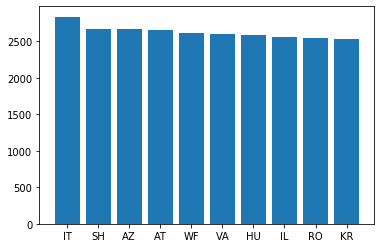

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# previous query result is in completedSessions
numSessions = completedSessions.toPandas()

x = np.arange(len(numSessions['count(session_id)']))
plt.bar(x, numSessions['count(session_id)'])
plt.xticks(x, numSessions['country'])
plt.show()